In [ ]:
import os
import random
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
from uuid import uuid4

import albumentations as al
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torchvision.models import resnet18, ResNet18_Weights

from sklearn.metrics import accuracy_score, precision_score, recall_score

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def augment_dataset(directory, transform, augmentations=1):
    classes = [cls for cls in os.listdir(directory) if os.path.isdir(os.path.join(directory, cls))]
    for cls in classes:
        class_path = os.path.join(directory, cls)
        images = [f for f in os.listdir(class_path) if not f.startswith('.')]
        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            image = cv.imread(img_path)
            if image is None:
                continue
            for _ in range(augmentations):
                aug = transform(image=image)['image']
                ext = os.path.splitext(img_name)[1]
                new_name = f"{os.path.splitext(img_name)[0]}_aug_{uuid4().hex[:6]}{ext}"
                cv.imwrite(os.path.join(class_path, new_name), aug)

In [ ]:
# ENTRENAMIENTO Y EVALUACIÓN DE MODELO RESNET18 --

def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        model.eval()
        val_loss, all_preds, all_labels = 0.0, [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        history['train_loss'].append(train_loss / len(train_loader.dataset))
        history['val_loss'].append(val_loss / len(val_loader.dataset))
        history['val_accuracy'].append(accuracy_score(all_labels, all_preds))

        print(f"[{epoch+1}/{epochs}] Train Loss: {history['train_loss'][-1]:.4f}, "
              f"Val Loss: {history['val_loss'][-1]:.4f}, "
              f"Val Acc: {history['val_accuracy'][-1]:.4f}")

    return history

In [ ]:
def evaluate_model(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\nEvaluación del modelo:")
    print(f"Accuracy:  {accuracy_score(all_labels, all_preds):.4f}")
    print(f"Precision: {precision_score(all_labels, all_preds):.4f}")
    print(f"Recall:    {recall_score(all_labels, all_preds):.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=loader.dataset.classes)
    disp.plot(cmap='Blues')
    plt.title("Matriz de Confusión")
    plt.show()


In [ ]:
def load_and_resize_image(input_path, output_path, size):
    try:
        img = cv.imread(input_path)
        if img is not None:
            resized = cv.resize(img, size)
            os.makedirs(os.path.dirname(output_path), exist_ok=True)
            cv.imwrite(output_path, resized)
            return True
    except Exception as e:
        print(f"Error con {input_path}: {e}")
    return False

In [ ]:
def process_directory(input_dir, output_dir, resize_shape):
    classes = [cls for cls in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, cls))]
    distribution = {}
    for cls in classes:
        in_class = os.path.join(input_dir, cls)
        out_class = os.path.join(output_dir, cls)
        files = [f for f in os.listdir(in_class) if not f.startswith('.')]
        distribution[cls] = 0
        for f in files:
            if load_and_resize_image(os.path.join(in_class, f), os.path.join(out_class, f), resize_shape):
                distribution[cls] += 1
    return distribution

In [ ]:
def plot_training(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Entrenamiento')
    plt.plot(history['val_loss'], label='Validación')
    plt.title('Pérdida por época')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['val_accuracy'], label='Accuracy')
    plt.title('Accuracy por época')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

       train  test  valid
RD       420    90     90
NO_RD    420    90     90


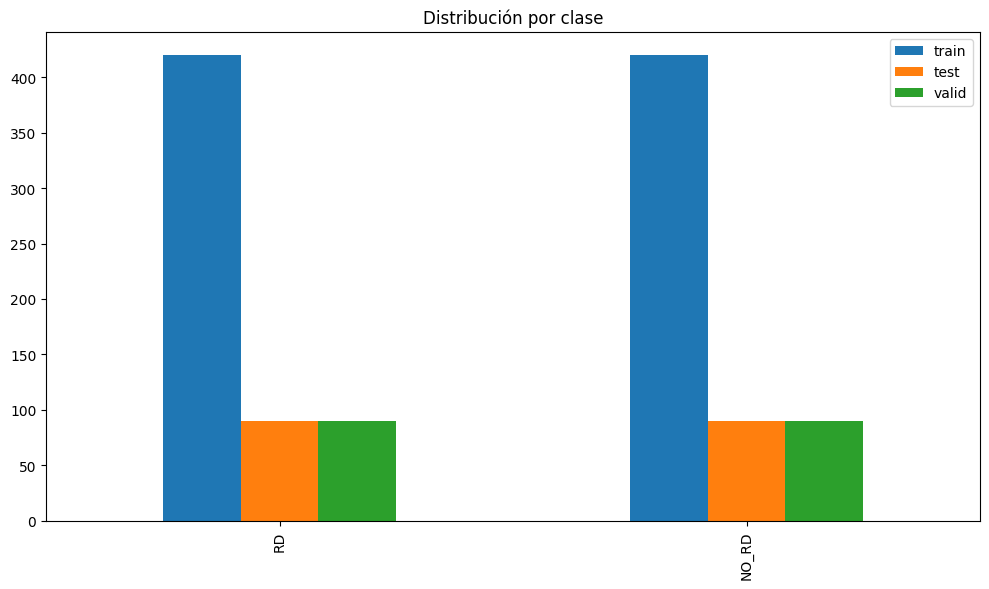

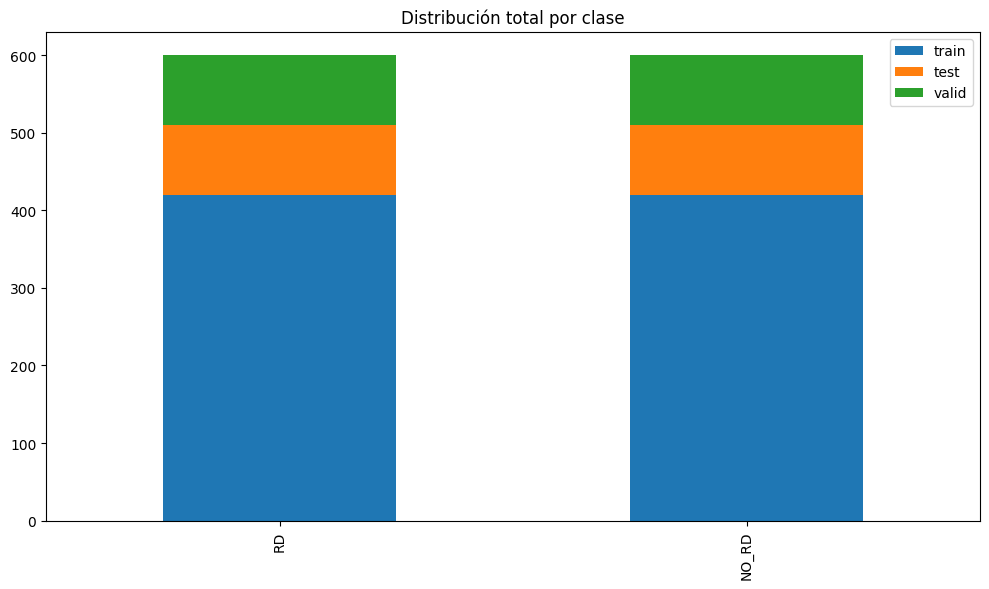

[1/10] Train Loss: 0.2810, Val Loss: 1.0909, Val Acc: 0.6889
[2/10] Train Loss: 0.0641, Val Loss: 1.4680, Val Acc: 0.7000
[3/10] Train Loss: 0.0394, Val Loss: 1.9035, Val Acc: 0.6111
[4/10] Train Loss: 0.0340, Val Loss: 1.3974, Val Acc: 0.7167
[5/10] Train Loss: 0.0313, Val Loss: 1.5420, Val Acc: 0.7000
[6/10] Train Loss: 0.0244, Val Loss: 1.3949, Val Acc: 0.7167
[7/10] Train Loss: 0.0219, Val Loss: 1.5775, Val Acc: 0.7000
[8/10] Train Loss: 0.0219, Val Loss: 1.8442, Val Acc: 0.6333
[9/10] Train Loss: 0.0190, Val Loss: 1.8304, Val Acc: 0.6444
[10/10] Train Loss: 0.0156, Val Loss: 1.7935, Val Acc: 0.6889


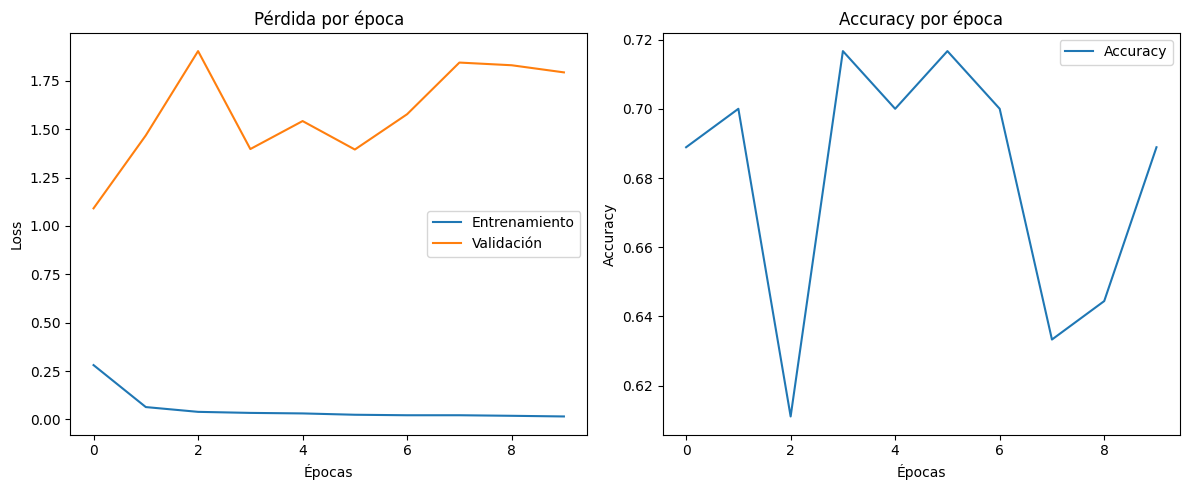


Evaluación del modelo:
Accuracy:  0.6333
Precision: 0.6176
Recall:    0.7000


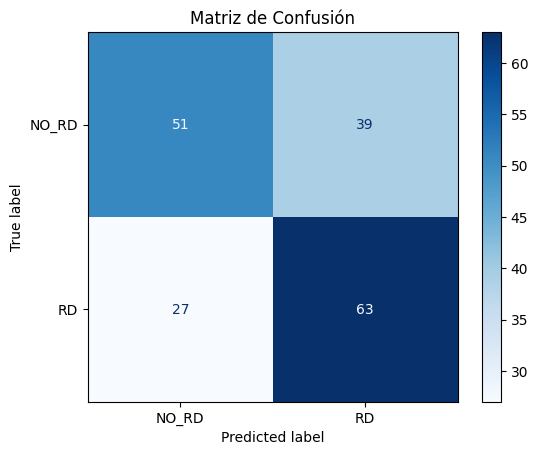

In [ ]:
if __name__ == '__main__':
    original_data = '../content/drive/MyDrive/Original_data'
    processed_data = '../content/drive/MyDrive/Processed_data'
    resize_shape = (256, 256)
    segmentos = ['train', 'test', 'valid']
    resultados = {s: process_directory(os.path.join(original_data, s),
                                       os.path.join(processed_data, s),
                                       resize_shape)
                  for s in segmentos}

    df = pd.DataFrame(resultados).fillna(0).astype(int)
    print(df)

    df.plot(kind='bar', figsize=(10, 6), title="Distribución por clase")
    plt.tight_layout(); plt.show()

    df.plot(kind='bar', stacked=True, figsize=(10, 6), title="Distribución total por clase")
    plt.tight_layout(); plt.show()

    # Aumentación
    transform = al.Compose([
        al.HorizontalFlip(p=0.5),
        al.VerticalFlip(p=0.5),
        al.Rotate(limit=45, p=0.5)
    ])
    augment_dataset(os.path.join(processed_data, 'train'), transform)

    # Carga de datos
    transformar = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    train_data = datasets.ImageFolder(os.path.join(processed_data, 'train'), transform=transformar)
    valid_data = datasets.ImageFolder(os.path.join(processed_data, 'valid'), transform=transformar)
    test_data  = datasets.ImageFolder(os.path.join(processed_data, 'test'),  transform=transformar)

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)
    test_loader  = DataLoader(test_data,  batch_size=32, shuffle=False)

    # Modelo
    pesos = ResNet18_Weights.DEFAULT
    model = resnet18(weights=pesos)
    model.fc = nn.Linear(model.fc.in_features, 2)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Entrenamiento
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    history = train_model(model, train_loader, valid_loader,
                          criterion, optimizer, device, epochs=10)

    plot_training(history)
    evaluate_model(model, test_loader, device)

In [ ]:
torch.save(model.state_dict(), 'modelo.pth')